---
# [aCompCor](https://linescanning.readthedocs.io/en/latest/classes/preproc.html#linescanning.preproc.aCompCor) for line-scanning

This notebook illustrates how to anatomical component correction (aCompCor) on line-scanning data. Though this may seem trivial on regular whole-brain fMRI data, the effect of aCompCor on line-scanning data is quite pronounced and therefore worthy of its own example notebook. We'll then also perform a quick analysis, and you can compare the results with the [nideconv](https://linescanning.readthedocs.io/en/latest/examples/nideconv.html) example.

In [153]:
%matplotlib inline

In [154]:
# imports
from linescanning import (
    dataset, 
    plotting, 
    utils, 
    fitting
    )
import warnings
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns

warnings.simplefilter('ignore')
project_dir     = "/mnt/d/FSL/shared/spinoza/projects"
base_dir        = opj(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = True

For aCompCor, we need some preparation steps before we can load everything in. We need the following:

- **A registration matrix mapping `ses-1` to the line-scanning session (e.g., `ses-3`)**; this one is generally obtained during the planning of the line with `spinoza_lineplanning`, but can be tailored to be closer to the first anatomical slice. For instance, we often acquire `multi-slice` images inbetween runs. Given that these images are often closer the line-scanning run, you can use `call_ses1_to_motion1` to create a matrix mapping `ses-1` to the first anatomical slice. 
- **Transformations mapping run-to-run**; the matrix above deals with session-to-session registration, but not motion inbetween runs. We can not see *every* bit of motion due to the 2D-nature of the data, but we can do our best. To get these registration matrices I use `ITK-Snap`. We'll define `run-1` as *moving* run, and the subsequent runs as *reference* runs. This means we need to open the *reference* images as `main` image in ITK-Snap, and the run-1 slice (*moving*) as overlay. Press `Tools` > `Registration` > `Manual` and align the slices to the best of your abilities. Then save the matrix by pressing the `save` icon on the bottom left as: `from-run1_to-run<run_ID>.txt` in the `anat`-folder of your line-scanning session

Now we have the ingredients to do aCompCor. For each run, the segmentations of `ses-1` will be transformed to the particular run using the 2 matrices provided (providing only 1 will lead to inaccurate alignment). We then perform PCA on the WM/CSF voxel timecourses. To eliminate the possibility of filtering out task-related frequencies, we high-pass the resulting components, before regressing them out. This is all done for you within the `linescanning.Dataset`-class.

In [155]:
# Load data
sub         = '003'
ses         = 3
task        = "task-SR"
runs        = [3,4,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(os.path.dirname(func_dir), 'anat')
ribbon      = (356,363)

run_files   = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
exp_file    = utils.get_file_from_substring("events.tsv", run_files)
anat_slices = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir)
ref_slices  = utils.match_lists_on(func_file, anat_slices, matcher='run')
ref_slices

['/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-3_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-4_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-6_T1w.nii.gz']

Now we insert everything again in `dataset` as before, but now you'll see it outputs plots regarding the effect of aCompCor on the data

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Baseline is 20 seconds, or 190 TRs
 Cutting 50 volumes from beginning (also cut from baseline (was 190, now 140 TRs)
 DCT-high pass filter [removes low frequencies <0.01 Hz] to correct low-frequency drifts.
 Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-3
 Foldover: FH
 Ref slice: /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-3_T1w.nii.gz
 Trafo's: ['/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/pycortex/sub-003/transforms/sub-003_from-ses1_to-ses3_rec-motion1_desc-genaff.mat', '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/from-run2_to-run3.txt']
 Found 25 voxel for nuisance regression; (indices<300 are ignored due to distance from coil)
 We're good to g

onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     35.213706
            2.13914868391734    39.913720
            3.5652478065289     47.413652
            2.014613132977678   53.213640
...                                   ...
        6   1.140879298089248  373.028252
            1.853928859395028  378.111696
            1.140879298089248  382.953138
            2.13914868391734   387.653167
            2.014613132977678  394.244731

[150 rows x 1 columns]

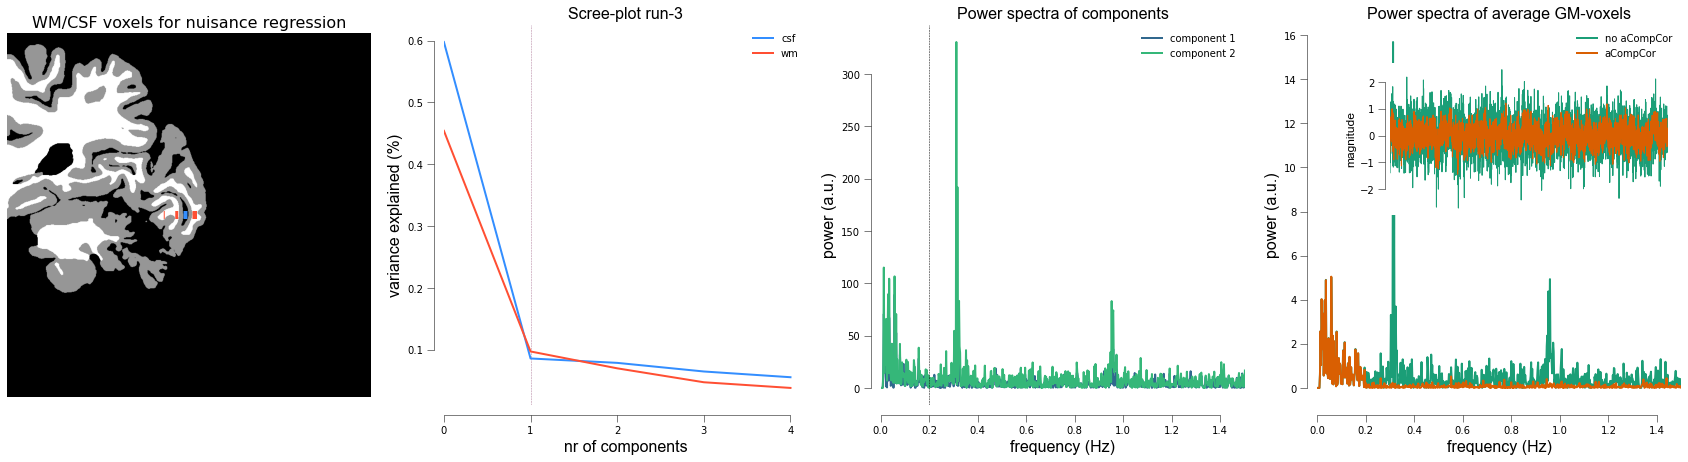

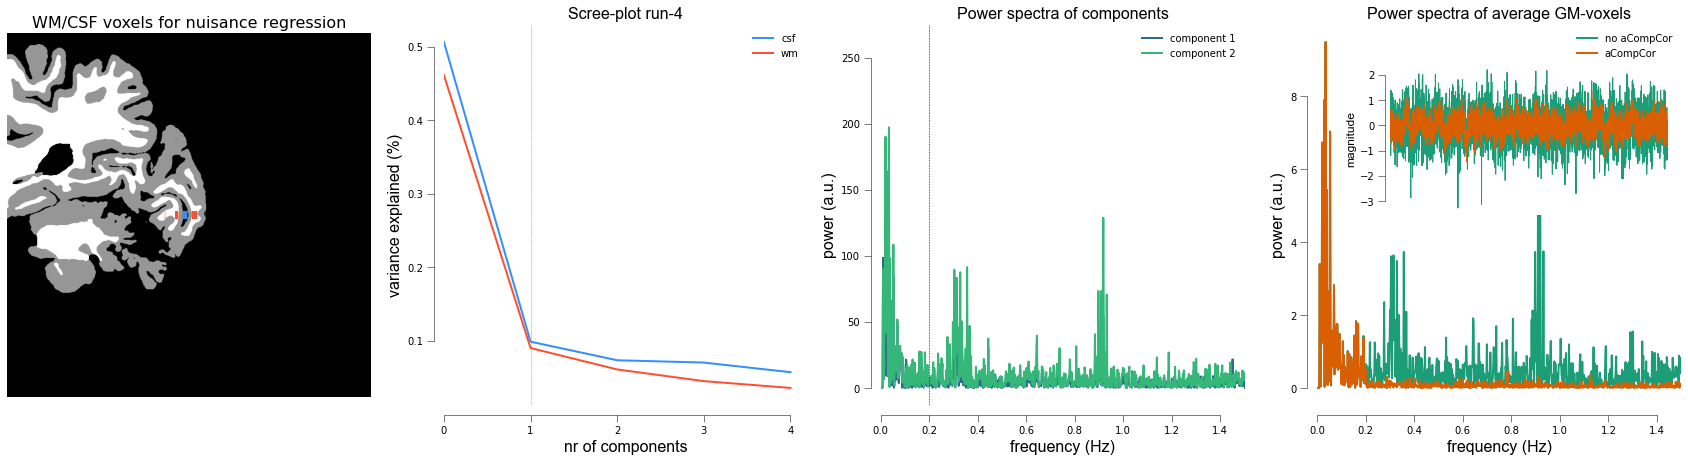

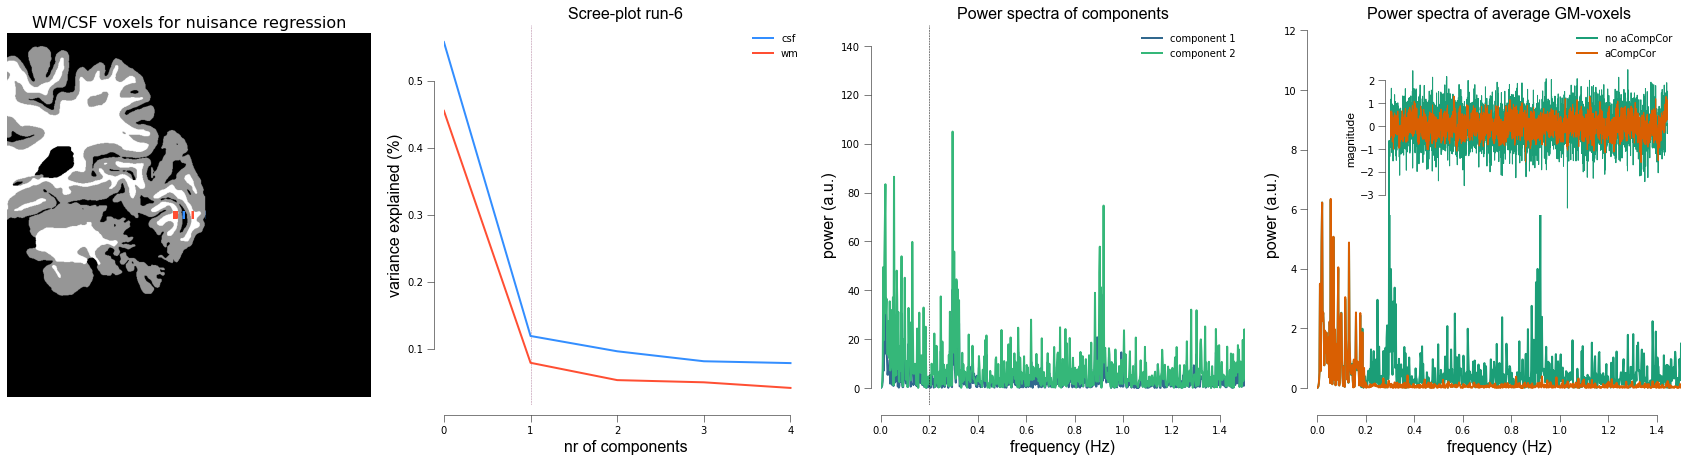

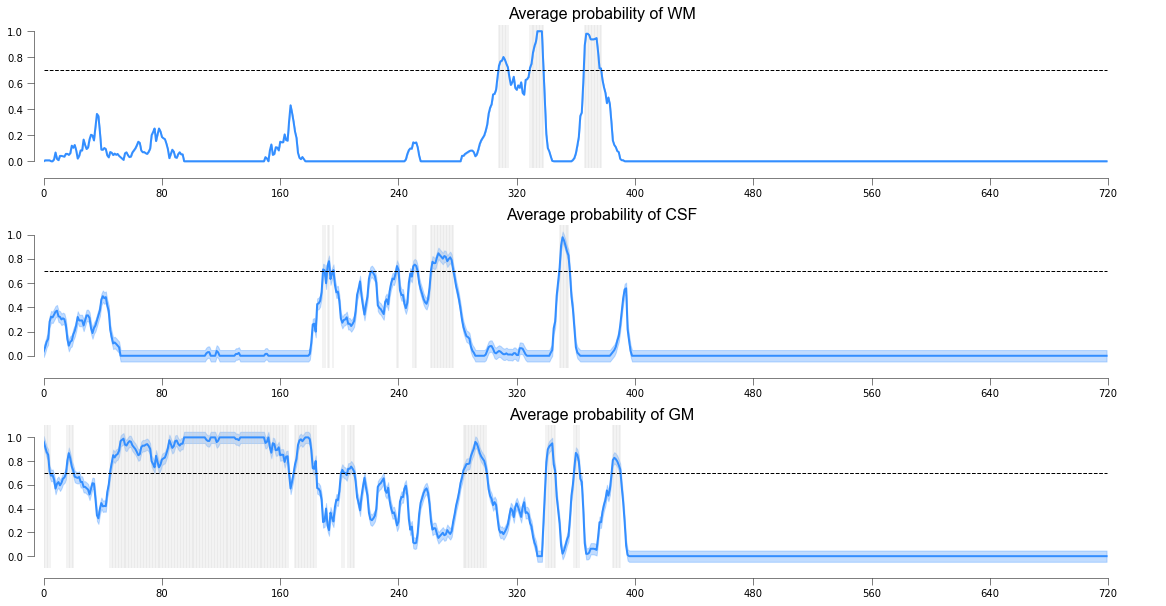

In [213]:
# mind you, the segmentations live in ses-1 space, NOT FREESURFER!
ses_to_motion = utils.get_file_from_substring(f"ses{ses}_rec-motion1", opj(deriv_dir, 'pycortex', f"sub-{sub}", 'transforms'))
run2run = utils.get_file_from_substring(['.txt'], anat_dir)

# initiate object
data_obj = dataset.Dataset(
    func_file,
    tsv_file=exp_file,
    deleted_first_timepoints=50, 
    deleted_last_timepoints=50,
    use_bids=True,
    verbose=True,
    acompcor=True,
    ref_slice=ref_slices,
    ses1_2_ls=ses_to_motion,
    run_2_run=run2run,
    n_pca=5,
    report=False)

df_func     = data_obj.fetch_fmri()
df_onsets   = data_obj.fetch_onsets()
df_onsets

For each run, the following is plotted:

- The WM (red) and CSF (blue) voxels used for PCA
- The scree plot of WM/CSF
- The power spectra of the selected components
- The power spectra of a real voxel timecourse before (green) and after (orange) aCompCor

You should be able to see that breathing-related frequencies (~0.25-0.3Hz) and cardiac frequencies (~1Hz) are largely removed. Now we're back with a dataframe that we can use with `NideconvFitter` as [before](https://linescanning.readthedocs.io/en/latest/examples/nideconv.html)

We can save the object as an `h5`-file

In [214]:
data_obj.to_hdf()

Saving to /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/lsprep/sub-003/ses-3/dataset.h5
 Storing attribute: df_func_psc
 Storing attribute: df_func_raw
 Storing attribute: df_onsets
Done


And read from that file later on

In [215]:
data_obj2 = dataset.Dataset(data_obj.h5_file)
df_func2 = data_obj2.fetch_fmri()
df_func2.head()

vox 0      vox 1     vox 2      vox 3      vox 4  \
subject run t                                                             
003     3   0.000 -11.268791  20.675842  3.643059   5.464417  19.831787   
            0.105   5.220299   3.646629  1.561874 -18.175636  11.372185   
            0.210  16.124245   4.645760 -9.609238  14.061096   3.064301   
            0.315   0.274521   2.146027  9.739418  11.125603   2.868805   
            0.420   0.011894 -12.099632 -4.228523  20.763100  -2.864799   

                       vox 5      vox 6     vox 7      vox 8     vox 9  ...  \
subject run t                                                           ...   
003     3   0.000  -1.580231  -5.665932  8.045868   1.001884  7.231850  ...   
            0.105  13.392868   1.031944  4.021049  -7.899956 -0.733025  ...   
            0.210  14.061806   1.619110 -9.753319   7.980743 -4.526749  ...   
            0.315  16.629951  14.436333  3.256439  -2.695702  8.151466  ...   
            0.420   4.398376   2.538567  1.098625  10.500237  5.553429  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
003     3   0.000  -6.231232   1.926201 -26.192245  10.043640  19.279381   
            0.105  37.002457  -0.116684  54.194107  65.822792  25.281830   
            0.210  17.694405 -38.169361 -25.722763  21.115028  26.644882   
            0.315 -20.756516  29.955048  -2.776077 -12.668266   9.367783   
            0.420  14.928970   0.116684 -42.732121  -1.089157  32.637619   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
003     3   0.000  37.216156  -5.807785 -36.261780 -38.368538   8.164024  
            0.105 -16.733543  43.018570  45.518127 -25.205460 -20.410423  
            0.210 -31.216881 -13.721283  -7.407021 -85.227013  17.002090  
            0.315  -1.626862  29.095657  36.880600 -31.587967   8.983261  
            0.420 -20.906685  12.145576 -47.056499 -35.285698 -22.710487  

[5 rows x 720 columns]

And we see it's the same as the original dataframe

In [216]:
df_func.head()

vox 0      vox 1     vox 2      vox 3      vox 4  \
subject run t                                                             
003     3   0.000 -11.268791  20.675835  3.643044   5.464417  19.831787   
            0.105   5.220299   3.646629  1.561874 -18.175636  11.372177   
            0.210  16.124245   4.645760 -9.609238  14.061096   3.064301   
            0.315   0.274521   2.146027  9.739418  11.125603   2.868805   
            0.420   0.011894 -12.099632 -4.228523  20.763100  -2.864799   

                       vox 5      vox 6     vox 7      vox 8     vox 9  ...  \
subject run t                                                           ...   
003     3   0.000  -1.580238  -5.665955  8.045868   1.001877  7.231834  ...   
            0.105  13.392868   1.031937  4.021049  -7.899956 -0.733032  ...   
            0.210  14.061806   1.619110 -9.753319   7.980743 -4.526756  ...   
            0.315  16.629951  14.436325  3.256439  -2.695702  8.151459  ...   
            0.420   4.398376   2.538567  1.098625  10.500237  5.553421  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
003     3   0.000  -6.231232   1.926208 -26.192238  10.043640  19.279381   
            0.105  37.002457  -0.116684  54.194107  65.822784  25.281830   
            0.210  17.694405 -38.169361 -25.722763  21.115021  26.644882   
            0.315 -20.756516  29.955048  -2.776077 -12.668274   9.367783   
            0.420  14.928970   0.116684 -42.732121  -1.089165  32.637619   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
003     3   0.000  37.216156  -5.807785 -36.261780 -38.368538   8.164032  
            0.105 -16.733543  43.018570  45.518127 -25.205460 -20.410423  
            0.210 -31.216881 -13.721283  -7.407021 -85.227013  17.002090  
            0.315  -1.626862  29.095657  36.880600 -31.587967   8.983261  
            0.420 -20.906685  12.145576 -47.056499 -35.285698 -22.710487  

[5 rows x 720 columns]

In [217]:
df_ribbon = utils.select_from_df(df_func, expression='ribbon', indices=ribbon)
df_ribbon

vox 356   vox 357   vox 358   vox 359   vox 360  \
subject run t                                                           
003     3   0.000    1.291512  1.673355  1.014061 -2.534836 -3.339226   
            0.105   -0.447891 -1.858551 -0.716454  0.316788  0.699753   
            0.210   -0.154091  1.333786  2.301636  0.543060 -2.958763   
            0.315    0.172256 -0.484093  1.191910 -2.388977  0.547112   
            0.420    2.191238  2.933685  0.419159  2.834633 -0.912834   
...                       ...       ...       ...       ...       ...   
        6   450.975 -0.236420  1.703430 -0.970016  0.522400 -1.332176   
            451.080  3.710991 -0.338005  2.691162  2.280724  2.631653   
            451.185 -1.374130  2.831108  1.778107  0.244553  0.808685   
            451.290  4.197334 -0.125290  1.121880  2.262886  2.393730   
            451.395 -0.605896 -0.387215  0.771240  0.216942  1.775818   

                      vox 361   vox 362  
subject run t                            
003     3   0.000   -5.837669 -4.163422  
            0.105    1.557922  2.709091  
            0.210   -2.669579 -1.719719  
            0.315   -2.186348  1.335533  
            0.420    1.509354 -1.473946  
...                       ...       ...  
        6   450.975  1.864960  0.403328  
            451.080  0.467567 -0.265831  
            451.185  3.256577  0.594902  
            451.290 -0.269264  0.664070  
            451.395  1.373344  1.178215  

[13300 rows x 7 columns]

Right, on to the fitting: we can do the fitting with `utils.NideconvFitter`, which requires the functional dataframe, onset dataframe, and some settings on the type of fit you'd like to do, number of regressors, confounds, etc. 

In [218]:
# we can fit with canonical HRFs
nd_gamma = fitting.NideconvFitter(
    df_ribbon,
    df_onsets,
    confounds=None,
    basis_sets='canonical_hrf_with_time_derivative',
    n_regressors=None,
    lump_events=False,
    TR=0.105,
    interval=[0, 18],
    add_intercept=True,
    verbose=True)

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


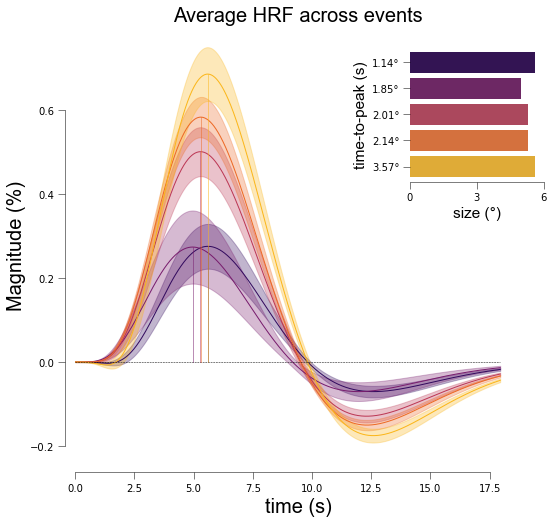

In [135]:
# instantiating figure allows insets to be saved too
font_size = 20
fig,axs = plt.subplots(figsize=(8,8))
nd_gamma.plot_average_per_event(
    xkcd=False,
    alpha=0.2,
    font_size=font_size,
    axs=axs ,
    x_label="time (s)",
    y_label="Magnitude (%)",
    add_hline='default',
    ttp=True,
    ttp_lines=True,
    add_labels=True,
    y_label2="time-to-peak (s)",
    x_label2="size (°)",
    ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_gamma.cond],
    lim=[0, 6],
    ticks=[0, 3, 6],
    cmap='inferno')
fig.savefig(opj(func_dir, "hrf_events_ttp.png"))


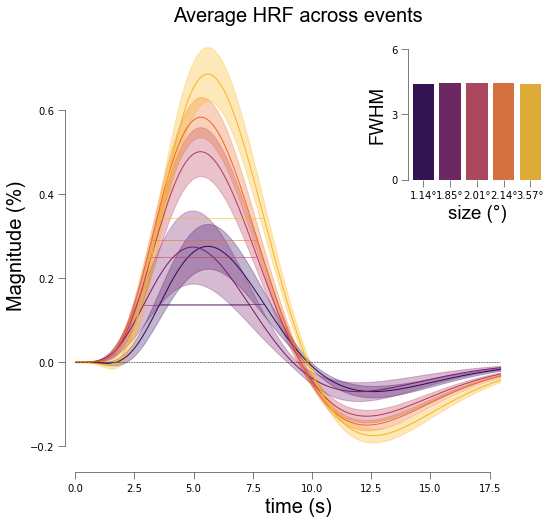

In [137]:
# instantiating figure allows insets to be saved too
fig,axs = plt.subplots(figsize=(8,8))
nd_gamma.plot_average_per_event(
    xkcd=False,
    alpha=0.2,
    font_size=font_size,
    axs=axs ,
    x_label="time (s)",
    y_label="Magnitude (%)",
    add_hline='default',
    fwhm=True,
    fwhm_lines=True,
    add_labels=True,
    y_label2="FWHM",
    x_label2="size (°)",
    fwhm_labels=[f"{round(float(ii),2)}°" for ii in nd_gamma.cond],
    lim=[0, 6],
    ticks=[0, 3, 6],
    cmap='inferno')
fig.savefig(opj(func_dir, "hrf_events_fwhm.png"))


Here we consider the predictions that arise from the deconvolved HRF

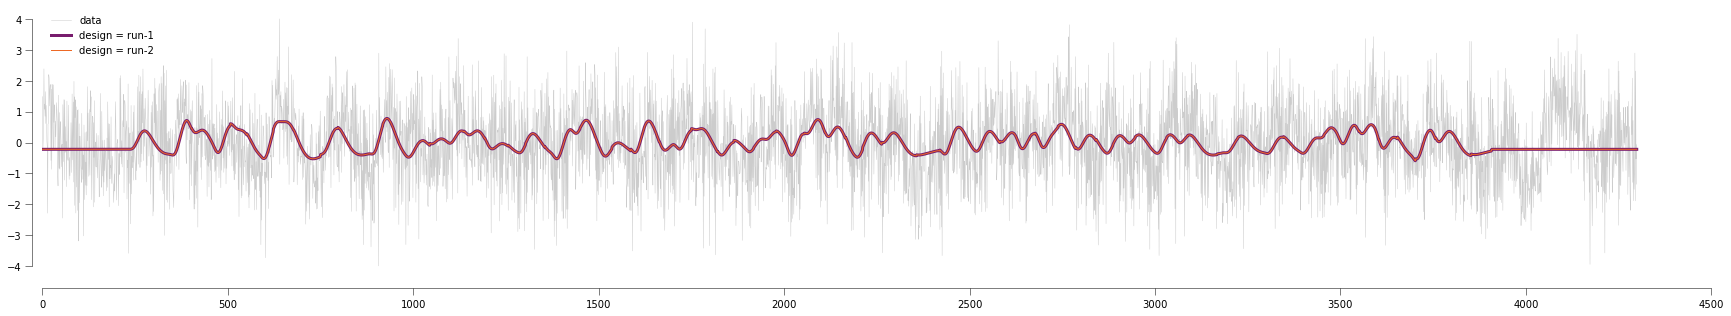

In [12]:
colors = sns.color_palette('inferno', 2)
cross_pred = nd_gamma.fitters.iloc[0].X.dot(nd_gamma.fitters.iloc[0].betas)

plotting.LazyPlot(
    [utils.select_from_df(df_ribbon, expression="run = 3").iloc[:,0].values, 
    utils.select_from_df(nd_gamma.predictions, expression="run = 3").iloc[:,0].values,
    cross_pred.iloc[:,0].values], 
    line_width=[0.5,3,1], 
    color=["#cccccc"]+colors,
    labels=["data", "design = run-1", "design = run-2"])

In [14]:
# individual model fits
fit_objs = []
for ii in nd_gamma.cond:

    nd_fit = fitting.NideconvFitter(
        df_ribbon,
        utils.select_from_df(df_onsets, expression=f"event_type = {ii}"),
        confounds=None,
        basis_sets='canonical_hrf_with_time_derivative',
        n_regressors=None,
        lump_events=False,
        TR=0.105,
        interval=[0,18],
        add_intercept=True,
        verbose=True)

    nd_fit.timecourses_condition()
    fit_objs.append(nd_fit)

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.140879298089248' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.853928859395028' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '2.014613132977678' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '2.13914868391734' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


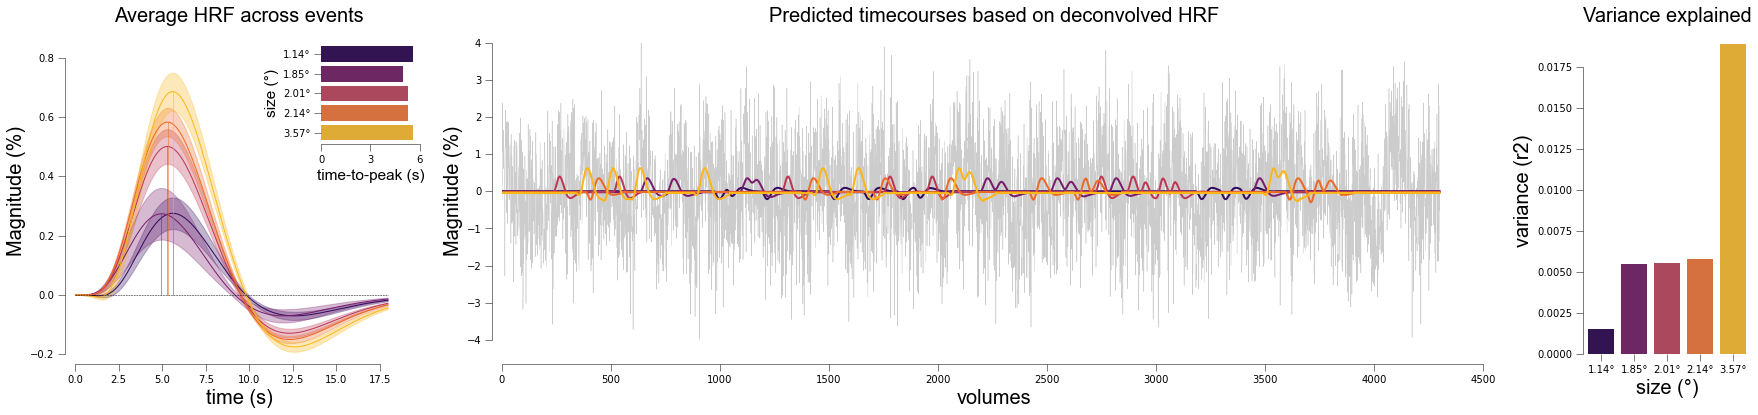

In [128]:
fig = plt.figure(figsize=(30,6))
gs = fig.add_gridspec(1,3, width_ratios=[1,3,0.5], wspace=0.2)
font_size = 20

ax1 = fig.add_subplot(gs[0])
nd_gamma.plot_average_per_event(
    xkcd=False,
    alpha=0.2,
    axs=ax1,
    x_label="time (s)",
    y_label="Magnitude (%)",
    add_hline='default',
    ttp=True,
    ttp_lines=True,
    add_labels=True,
    y_label2="size (°)",
    x_label2="time-to-peak (s)",
    ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_gamma.cond],
    lim=[0, 6],
    ticks=[0, 3, 6],
    cmap='inferno',
    y_lim=[-0.2,0.9],
    font_size=font_size)

ax2 = fig.add_subplot(gs[1])
colors = sns.color_palette('inferno', len(nd_gamma.cond))
preds = [utils.select_from_df(fit_objs[ii].predictions, expression="run = 3").iloc[:,0].values for ii in range(len(fit_objs))]
real = utils.select_from_df(df_ribbon, expression="run = 3").iloc[:,0].values

plotting.LazyPlot(
    [real]+preds,
    line_width=[0.5]+[2 for ii in range(len(fit_objs))], 
    color=["#cccccc"]+colors,
    axs=ax2,
    title="Predicted timecourses based on deconvolved HRF",
    font_size=font_size,
    x_label="volumes",
    y_label="Magnitude (%)")

# calculate r2's
ax3 = fig.add_subplot(gs[2])
r2s = [r2_score(real, preds[ii]) for ii in range(len(fit_objs))]
plotting.LazyBar(
    x=[f"{round(float(ii),2)}°" for ii in nd_gamma.cond],
    y=r2s,
    palette=colors,
    sns_ori="v",
    axs=ax3,
    add_labels=True,
    x_label2="size (°)",
    y_label2="variance (r2)",
    font_size=font_size,
    title2="Variance explained")

fig.savefig(opj(func_dir, "r2_score.png"))


In [59]:
cross_pred.iloc[:,0].values

array([-0.21889215, -0.21889215, -0.21889215, ..., -0.21889215,
       -0.21889215, -0.21889215])

In [53]:
cross_pred = nd_gamma.fitters.iloc[0].predict_from_design_matrix(X=nd_gamma.fitters.iloc[1].X)
cross_pred

,prediction for vox 356,prediction for vox 357,prediction for vox 358,prediction for vox 359,prediction for vox 360,prediction for vox 361,prediction for vox 362
time,,,,,,,
0.000,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.105,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.210,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.315,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.420,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
...,...,...,...,...,...,...,...
450.975,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
451.080,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
451.185,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665


In [44]:
# we can fit with fourier
nd_fourier = fitting.NideconvFitter(
    df_ribbon,
    df_onsets,
    confounds=None,
    basis_sets='fourier',
    n_regressors=4,
    lump_events=False,
    TR=0.105,
    interval=[0,18],
    add_intercept=False,
    verbose=True)

Selected 'fourier'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


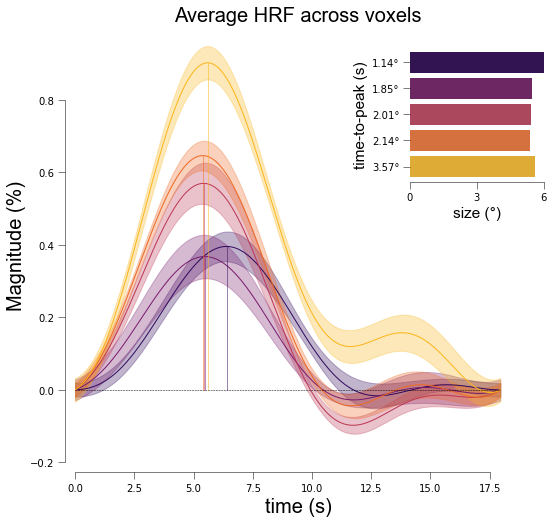

In [46]:
nd_fourier.plot_average_per_event(
    xkcd=False,
    figsize=(8, 8),
    x_label="time (s)",
    y_label="Magnitude (%)",
    add_hline='default',
    y_lim=[-0.2,1],
    ttp=True,
    ttp_lines=True,
    add_labels=True,
    y_label2="time-to-peak (s)",
    x_label2="size (°)",
    ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_fourier.cond],
    lim=[0, 6],
    ticks=[0, 3, 6],
    cmap='inferno',
    save_as=opj(func_dir, "hrf_fourier.png"),
    font_size=font_size)


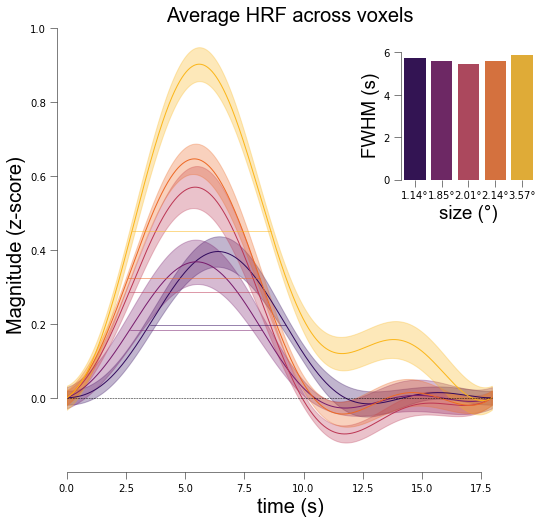

In [47]:
nd_fourier.plot_average_per_event(
    xkcd=False,
    alpha=0.2,
    x_label="time (s)",
    y_label="Magnitude (z-score)",
    add_hline='default',
    sns_trim=True,
    fwhm=True,
    fwhm_lines=True,
#   lim=[0,5],
#   ticks=[i for i in range(6)],
    fwhm_labels=[f"{round(float(ii),2)}°" for ii in nd_fourier.cond],
    add_labels=True,
    x_label2="size (°)",
    y_label2="FWHM (s)",
    cmap='inferno',
    font_size=font_size)


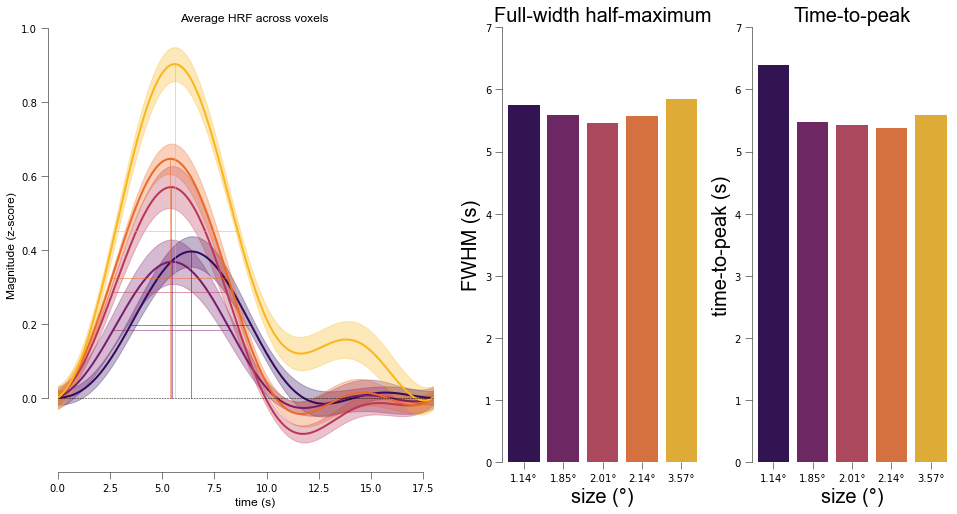

In [49]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,3, width_ratios=[2,1,1])

ax = fig.add_subplot(gs[0])
nd_fourier.plot_average_per_event(
    axs=ax,
    alpha=0.2,
    x_label="time (s)",
    y_label="Magnitude (z-score)",
    add_hline='default',
    line_width=2,
    cmap='inferno')

ax2 = fig.add_subplot(gs[1])
nd_fourier.plot_fwhm(
    nd_fourier.event_avg, 
    axs=ax2, 
    hrf_axs=ax, 
    fwhm_labels=[f"{round(float(ii),2)}°" for ii in nd_fourier.cond],
    x_label2="size (°)",
    y_label2="FWHM (s)",
    title2="Full-width half-maximum",
    add_labels=True,
    font_size=20,
    lim=[0, 7],
    fwhm_lines=True)

ax3 = fig.add_subplot(gs[2])
nd_fourier.plot_ttp(
    nd_fourier.event_avg, 
    axs=ax3,
    hrf_axs=ax, 
    ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_fourier.cond],
    y_label2="time-to-peak (s)",
    x_label2="size (°)",
    title2="Time-to-peak",
    add_labels=True,
    font_size=20,
    lim=[0,7],
    ttp_lines=True,
    ttp_ori='v')


In [61]:
nd_fourier.tc_condition

vox 356   vox 357   vox 358  \
event_type        covariate time                                          
1.140879298089248 intercept 0.000000   0.000000e+00  0.000000  0.000000   
                            0.005252   1.375372e-04  0.000103 -0.000108   
                            0.010503   2.759051e-04  0.000207 -0.000215   
                            0.015755   4.151058e-04  0.000311 -0.000321   
                            0.021006   5.551417e-04  0.000416 -0.000427   
...                                             ...       ...       ...   
3.5652478065289   intercept 17.928742 -1.893195e-03 -0.001270 -0.000615   
                            17.933994 -1.424503e-03 -0.000958 -0.000465   
                            17.939245 -9.527421e-04 -0.000642 -0.000313   
                            17.944497 -4.779088e-04 -0.000323 -0.000158   
                            17.949748 -1.110223e-16  0.000000  0.000000   

                                            vox 359       vox 360  \
event_type        covariate time                                    
1.140879298089248 intercept 0.000000   0.000000e+00  0.000000e+00   
                            0.005252  -5.058882e-05 -1.452925e-04   
                            0.010503  -1.007020e-04 -2.906136e-04   
                            0.015755  -1.503347e-04 -4.359589e-04   
                            0.021006  -1.994824e-04 -5.813240e-04   
...                                             ...           ...   
3.5652478065289   intercept 17.928742 -1.267904e-03  1.504100e-03   
                            17.933994 -9.548272e-04  1.124414e-03   
                            17.939245 -6.391520e-04  7.471626e-04   
                            17.944497 -3.208768e-04  3.723552e-04   
                            17.949748 -5.551115e-17  5.551115e-17   

                                            vox 361   vox 362  
event_type        covariate time                               
1.140879298089248 intercept 0.000000   0.000000e+00  0.000000  
                            0.005252   3.773805e-05  0.000079  
                            0.010503   7.652811e-05  0.000159  
                            0.015755   1.163712e-04  0.000240  
                            0.021006   1.572684e-04  0.000321  
...                                             ...       ...  
3.5652478065289   intercept 17.928742 -8.376547e-04 -0.001004  
                            17.933994 -6.315693e-04 -0.000756  
                            17.939245 -4.232665e-04 -0.000506  
                            17.944497 -2.127441e-04 -0.000254  
                            17.949748 -2.775558e-17  0.000000  

[17095 rows x 7 columns]

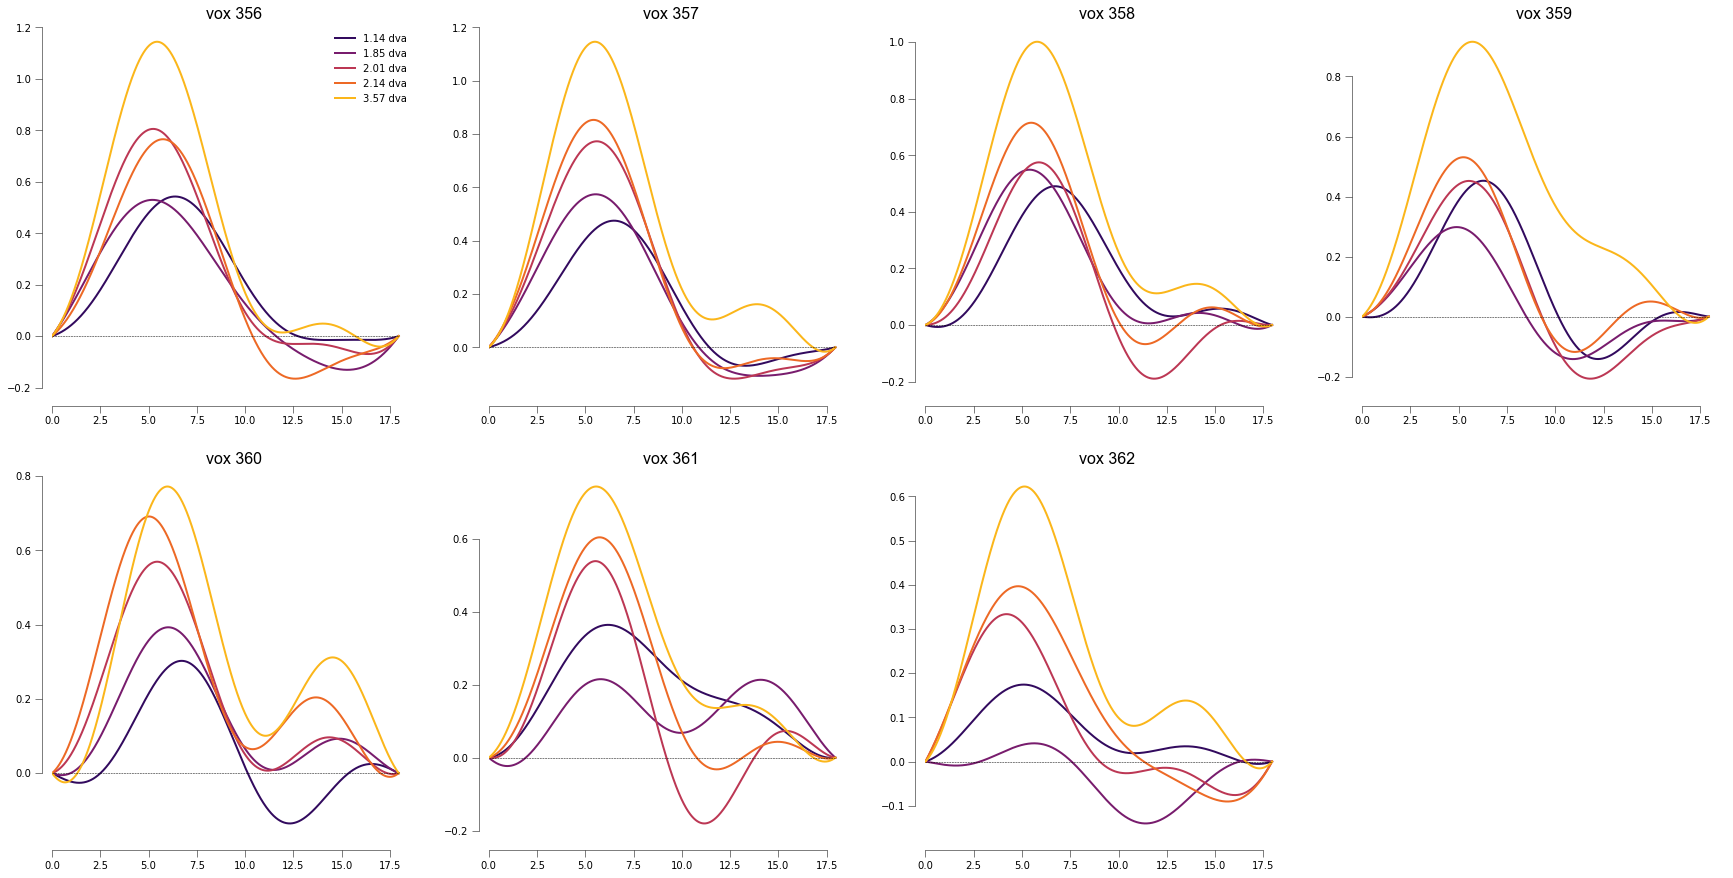

In [75]:
nd_fourier.plot_average_per_voxel(
    labels=[f"{round(float(ii),2)} dva" for ii in nd_fourier.cond],
    wspace=0.2,
    cmap="inferno",
    line_width=2,
    save_as=opj(func_dir, "hrf_fourier_voxel.png"))


The models above considered each stimulus event (stimulus size) as separate event. Again, we can also lump them together into a single event to get an `average HRF`

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event 'stim' to model
Fitting with 'ols' minimization
Done


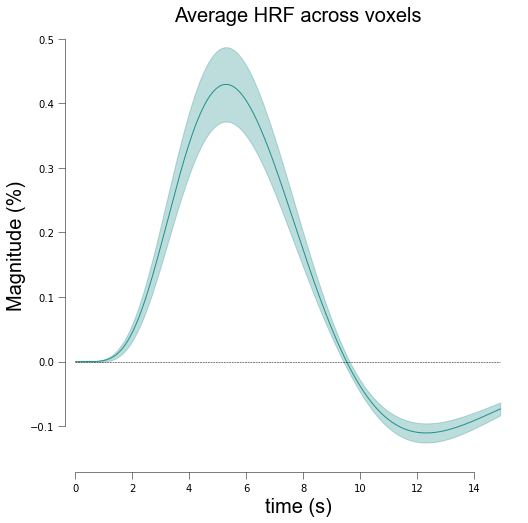

In [71]:
lumped = fitting.NideconvFitter(
    df_ribbon,
    df_onsets,
    confounds=None,
    basis_sets='canonical_hrf_with_time_derivative',
    n_regressors=4,
    lump_events=True,
    TR=0.105,
    interval=[0, 15],
    add_intercept=True,
    verbose=True,
    fit_type='ols')

lumped.plot_average_per_event(
    figsize=(8, 8),
    x_label="time (s)",
    y_label="Magnitude (%)",
    add_hline='default',
    font_size=font_size,
    save_as=opj(func_dir, "hrf_average.png"))


Then, we can also average across events, but not across depth. This should give use an HRF for each voxel along the cortical ribbon.

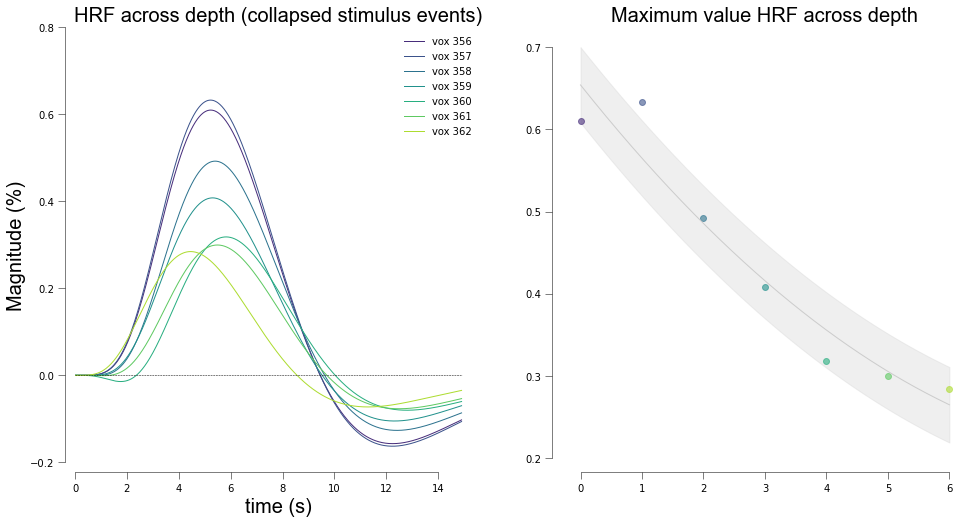

In [125]:
# plot individual voxels in 1 figure
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,2)

ax = fig.add_subplot(gs[0])
lumped.plot_average_per_voxel(
    n_cols=None,
    figsize=(8, 8),
    axs=ax,
    font_size=font_size,
    labels=True,
    title="HRF across depth (collapsed stimulus events)",
    x_label="time (s)",
    y_label="Magnitude (%)",
    y_lim=[-.2,0.8])

ax = fig.add_subplot(gs[1])
lumped.plot_hrf_across_depth(
    axs=ax,
    title="Maximum value HRF across depth",
    set_xlim_zero=False,
    font_size=font_size,
    order=2)

img = opj(func_dir, f"hrf_across_depth.png")
fig.savefig(img)
